[![Lab Documentation and Solutions](https://img.shields.io/badge/Lab%20Documentation%20and%20Solutions-purple)](https://mongodb-developer.github.io/vector-search-lab/)

# Step 1: Setup prerequisites

In [6]:
import os
from pymongo import MongoClient

In [7]:
# If you are using your own MongoDB Atlas cluster, use the connection string for your cluster here
MONGODB_URI = os.environ.get("MONGODB_URI")
# Initialize a MongoDB Python client
mongodb_client = MongoClient(MONGODB_URI, appname="devrel.workshop.vector_search")
# Check the connection to the server
mongodb_client.admin.command("ping")

{'ok': 1.0,
 '$clusterTime': {'clusterTime': Timestamp(1747238181, 1),
  'signature': {'hash': b'\x9e\x1a\xa4\x8f\\=\x80l\x1f\xa0\xa3k\x88\xc3AJ\x12\x16\x8a\x93',
   'keyId': 7504308584902033414}},
 'operationTime': Timestamp(1747238181, 1)}

# Step 2: Import data into MongoDB

In [8]:
import json

### **Do not change the values assigned to the variables below**

In [9]:
# Database name
DB_NAME = "mongodb_genai_devday_vs"
# Collection name
COLLECTION_NAME = "books"
# Name of the vector search index
ATLAS_VECTOR_SEARCH_INDEX_NAME = "vector_index"

In [10]:
# Connect to the `COLLECTION_NAME` collection.
collection = mongodb_client[DB_NAME][COLLECTION_NAME]

In [11]:
with open("data/books.json", "r") as data_file:
    json_data = data_file.read()

data = json.loads(json_data)

print(f"Deleting existing documents from the {COLLECTION_NAME} collection.")
collection.delete_many({})
collection.insert_many(data)
print(
    f"{collection.count_documents({})} documents ingested into the {COLLECTION_NAME} collection."
)

Deleting existing documents from the books collection.
50 documents ingested into the books collection.


# Step 3: Generating embeddings

In [12]:
# You may see a warning upon running this cell. You can ignore it.
from sentence_transformers import SentenceTransformer
from PIL import Image
import requests

/home/codespace/.python/current/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Load a multimodal embedding model using the Sentence Transformers library
embedding_model = SentenceTransformer("clip-ViT-B-32")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### For images

📚 https://huggingface.co/sentence-transformers/clip-ViT-B-32#usage

In [14]:
image_url = "https://images.isbndb.com/covers/77/44/9780789467744.jpg"
# Load the image from the URL above
image = Image.open(requests.get(image_url, stream=True).raw)
# Embed the `image` using the `embedding_model` instantiated above and return the embedding as a list
# An array can be converted to a list using the `tolist()` method
embedding = embedding_model.encode(image).tolist()

In [15]:
print(embedding)

[0.2581808865070343, 0.19349519908428192, 0.38426458835601807, -0.11588269472122192, -0.270173043012619, -0.330142617225647, 0.43095681071281433, -0.08364661037921906, 0.17901253700256348, 0.27528852224349976, 0.5093525648117065, 0.07143685966730118, -0.230491504073143, 0.40923187136650085, 0.3859850764274597, -0.2702333927154541, 0.24901725351810455, 0.34622710943222046, 0.281629741191864, -0.39965400099754333, -0.8355398178100586, 0.1971851885318756, -0.028484951704740524, 0.8540525436401367, -0.394773006439209, -0.04850812256336212, 0.23687703907489777, 0.3688759505748749, -0.22900348901748657, 0.1452382653951645, -0.2987714409828186, 0.1124420240521431, -0.28458094596862793, 0.013283133506774902, -0.073150634765625, -0.06690604984760284, 0.18004891276359558, -0.0024228766560554504, 0.0770711749792099, -0.299815833568573, -0.1132093220949173, 0.1731386035680771, 0.0763525664806366, 0.23221440613269806, 0.06568276882171631, -1.1241580247879028, -0.3872729539871216, -0.059500262141227

### For text

In [16]:
text = "Puppy Preschool: Raising Your Puppy Right---Right from the Start!"
# Use the same `embedding_model` to embed a piece of text
embedding = embedding_model.encode(text).tolist()

In [17]:
print(embedding)

[-0.12503160536289215, -0.34212130308151245, -0.265405535697937, 0.012203648686408997, -0.13794107735157013, -0.051292575895786285, 0.4078461527824402, 0.18069614470005035, -0.26146450638771057, -0.370482861995697, -0.6959188580513, -0.17315256595611572, -0.15652354061603546, -0.2016841173171997, 0.05593734234571457, 0.0023418664932250977, -0.5091978907585144, -0.07782110571861267, 0.01800890639424324, 0.20341601967811584, -0.4840427041053772, -0.3236594796180725, 0.6865010857582092, 0.41892433166503906, 0.006406478583812714, -0.03999985754489899, 0.2711701989173889, 0.3239158093929291, -0.1873328983783722, -0.15335270762443542, 0.14605727791786194, -0.06396697461605072, 0.09700702875852585, -0.3382304608821869, -0.5776907205581665, 0.016878560185432434, -0.08471275866031647, 0.1157180517911911, -0.5809030532836914, -0.35574305057525635, 0.10551214963197708, 0.07549676299095154, -0.02413729578256607, 0.09987771511077881, 0.17345869541168213, -0.10375771671533585, 0.1400018185377121, -0

# Step 4: Adding embeddings to existing data in Atlas

In [18]:
from typing import List, Dict, Optional
from tqdm import tqdm

In [19]:
# Field in the documents to embed-- in this case, the book cover
field_to_embed = "cover"
# Name of the embedding field to add to the documents
embedding_field = "embedding"

In [20]:
def get_embedding(content: str, mode: str) -> List[float]:
    """
    Generate embeddings

    Args:
        content (str): Content to embed
        mode (str): Content mode (Can be one of "image" or "text")

    Returns:
        List[float]: Embedding of the content as a list.
    """
    # If an image URL is provided, first load the image
    if mode == "image":
        content = Image.open(requests.get(content, stream=True).raw)
    return embedding_model.encode(content).tolist()

📚 https://www.mongodb.com/docs/manual/tutorial/query-documents/#select-all-documents-in-a-collection

In [21]:
# Query for all documents in the `collection` collection.
results = collection.find({})

📚 **$set:** https://www.mongodb.com/docs/manual/reference/operator/update/set/#syntax

📚 **update_one():** https://www.mongodb.com/docs/manual/reference/method/db.collection.updateOne/#definition

In [22]:
# Update each document in the `collection` collection with embeddings
for result in tqdm(results):
    content = result[field_to_embed]
    # Use the `get_embedding` function defined above to embed the `content`
    # Note that `content` contains the cover image URL for the book 
    embedding = get_embedding(content, "image")

    
    # Filter for the document where the `_id` field is equal to the `_id` of the current document
    filter = {"_id": result["_id"]}
    # Set the `embedding_field` field to the value `embedding` using the `$set` operator
    update = {"$set": {embedding_field: embedding}}
    # Update the documents in the `collection` collection inplace using the `update_one()` operation
    # Get the right document `_id` using the `filter` and apply the `update`
    collection.update_one(filter, update)

50it [00:06,  7.55it/s]


# Step 5: Create a vector search index

In [23]:
# Create vector index definition specifying:
# path: Path to the embeddings field
# numDimensions: Number of embedding dimensions- depends on the embedding model used
# similarity: Similarity metric. One of cosine, euclidean, dotProduct.
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "cosine",
            }
        ]
    },
}

📚 https://pymongo.readthedocs.io/en/stable/api/pymongo/collection.html#pymongo.collection.Collection.create_search_index

In [24]:
# Create a vector search index with the above definition for the `collection` collection
collection.create_search_index(model=model)

'vector_index'

In [25]:
# Verify that the index was created and is in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}},
 {'id': '6824bb4ac1a00a285d630aeb',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'cosine'}]}}]

# Step 6: Perform vector search queries

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-examples (Refer to the "Filter Example")

In [26]:
# Define a function to retrieve relevant documents for a user query using vector search
def vector_search(
    user_query: str, mode: str, filter: Optional[Dict] = {}
) -> None:
    """
    Retrieve relevant documents for a user query using vector search.

    Args:
    user_query (str): The user's query (can be a piece of text or a link to an image)
    mode (str): Query mode (image or text)
    filter (Optional[Dict], optional): Optional vector search pre-filter
    """
    # Generate embedding for the `user_query` using the `get_embedding` function defined in Step 4
    query_embedding = get_embedding(user_query, mode)

    # Define an aggregation pipeline consisting of a $vectorSearch stage, followed by a $project stage
    # Set the number of candidates to 50 and only return the top 5 documents from the vector search
    # Set the `filter` field in the $vectorSearch stage to the value `filter` passed to the function
    # In the $project stage, exclude the `_id` field, include these fields: `title`, `cover`, `year`, `pages`, and the `vectorSearchScore`
    # NOTE: Use variables defined previously for the `index`, `queryVector` and `path` fields in the $vectorSearch stage
    pipeline = [
    {
        "$vectorSearch": {
            "index": ATLAS_VECTOR_SEARCH_INDEX_NAME,
            "queryVector": query_embedding,
            "path": "embedding",
            "numCandidates": 50,
            "filter": filter,
            "limit": 5,
        }
    },
    {"$project": {"_id": 0, "title": 1, "cover": 1, "year":1, "pages":1, "score": {"$meta": "vectorSearchScore"}}},
]

    # Execute the aggregation `pipeline` and store the results in `results`
    results = collection.aggregate(pipeline)

    # Print book title, score, and cover image
    for book in results:
        cover = Image.open(requests.get(book.get("cover"), stream=True).raw).resize((100,150))
        print(f"{book.get('title')}({book.get('year')}, {book.get('pages')} pages): {book.get('score')}")
        display(cover)

Country Living Decorating with Candles: Accents for Every Room(2000, 112 pages): 0.6298907995223999


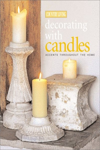

Beauty for Ashes: Receiving Emotional Healing(2003, 272 pages): 0.6147171258926392


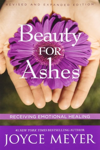

The Secrets of Bach Flower Remedies(2000, 224 pages): 0.6123381853103638


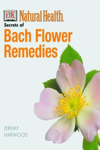

The Cat Who Came for Christmas(1995, 240 pages): 0.609235942363739


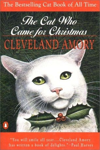

Ocean Sea(2000, 256 pages): 0.6091467142105103


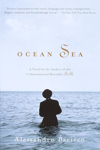

In [27]:
# Test the vector search with a text query
vector_search("A peaceful and uplifting atmosphere", "text")

# Also try these text queries:
# - Healthy living and fitness
# - A man wearing a golden crown
# - Adorable fluffy creatures
# - Winning business agreement
# - A Winter's Tale on a Spanish Isle

Café Royale: Tales of love & travel(1997, 282 pages): 0.7741575241088867


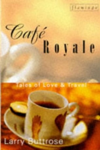

The Design of Everyday Things(1990, 272 pages): 0.7693169116973877


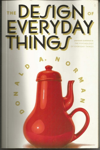

101 Essential Tips: House Plants(1996, 72 pages): 0.7468793392181396


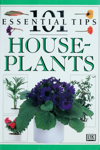

Juicing for Life: A Guide to the Benefits of Fresh Fruit and Vegetable Juicing(1991, 368 pages): 0.7460870146751404


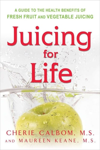

Country Living Decorating with Candles: Accents for Every Room(2000, 112 pages): 0.7417749166488647


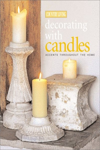

In [28]:
# Test the vector search with an image query
vector_search("https://mongodb-developer.github.io/vector-search-lab/img/query-sample/1.png", "image")

# Also try these image queries:
# - https://mongodb-developer.github.io/vector-search-lab/img/query-sample/1.png
# - https://mongodb-developer.github.io/vector-search-lab/img/query-sample/2.png
# - https://mongodb-developer.github.io/vector-search-lab/img/query-sample/3.png
# - https://mongodb-developer.github.io/vector-search-lab/img/query-sample/4.png
# - https://mongodb-developer.github.io/vector-search-lab/img/query-sample/5.png

# Step 7: Adding pre-filters to your vector search

### Filter for books that were published after the year `2002`

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#about-the-filter-type

In [29]:
# Modify the vector search index `model` from Step 5 to include the `year` field as a `filter` field
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "cosine",
            },
            {"type": "filter", "path": "year"},
        ]
    },
}

In [30]:
# Re-create the vector search index with the modified model
collection.drop_search_index(name=ATLAS_VECTOR_SEARCH_INDEX_NAME)
collection.create_search_index(model=model)

'vector_index'

In [31]:
# Verify that the index has the right filter fields and is in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}},
 {'id': '6824bd35c1a00a285d630aed',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'BUILDING',
  'queryable': False,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'cosine'},
    {'type': 'filter', 'path': 'year'}]}}]

📚 https://www.mongodb.com/docs/manual/reference/operator/query/gte/#syntax

Beauty for Ashes: Receiving Emotional Healing(2003, 272 pages): 0.6147171258926392


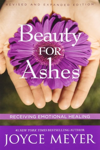

Asia's Best Hotels & Resorts (Insight Guides)(2003, 320 pages): 0.611221969127655


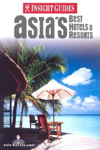

Puppy in a Puddle (Animal Ark Series #28)(2003, 144 pages): 0.6066393852233887


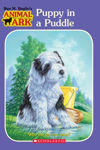

Snowball Oranges: A Winter's Tale on a Spanish Isle(2003, 240 pages): 0.6032916307449341


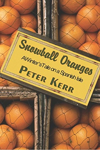

Raising Blaze: A Mother and Son's Long, Strange Journey into Autism(2003, 316 pages): 0.6014822721481323


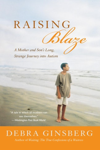

In [32]:
# Create a filter definition to filter for books where the `year` field is greater than `2002` using the `$gte` operator
filter = {"year": {"$gte": 2002}}
# Pass the `filter` as an argument to the `vector_search` function.
# Notice how this filter is incorporated in the `pipeline` in the `vector_search` function.
vector_search("A peaceful and uplifting atmosphere", "text", filter)

### Filter for books that were published after the year `2002` and under `250` pages

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#about-the-filter-type

In [33]:
# Modify the vector search index `model` from Step 5 to include `year` and `pages` as filter fields
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "cosine",
            },
            {"type": "filter", "path": "year"},
            {"type": "filter", "path": "pages"},
        ]
    },
}

In [34]:
# Re-create the vector search index with the modified model
collection.drop_search_index(name=ATLAS_VECTOR_SEARCH_INDEX_NAME)
collection.create_search_index(model=model)

'vector_index'

In [35]:
# Verify that the index has the right filter fields and is in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '6824bd35c1a00a285d630aee',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'PENDING',
  'queryable': False,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'cosine'},
    {'type': 'filter', 'path': 'year'},
    {'type': 'filter', 'path': 'pages'}]}},
 {'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}}]

📚 https://www.mongodb.com/docs/manual/reference/operator/query/lte/#mongodb-query-op.-lte

Puppy in a Puddle (Animal Ark Series #28)(2003, 144 pages): 0.6066393852233887


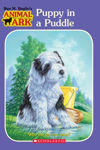

Snowball Oranges: A Winter's Tale on a Spanish Isle(2003, 240 pages): 0.6032916307449341


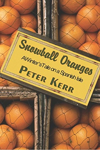

Christmas Crisis (Sabrina, the Teenage Witch)(2003, 160 pages): 0.595951497554779


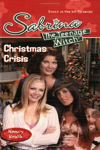

Electric Storm: Magic School Bus Chapter Book #14(2003, 96 pages): 0.5926523208618164


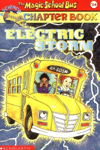

I Do: A Guide to Creating Your Own Unique Wedding Ceremony(2004, 152 pages): 0.5900998115539551


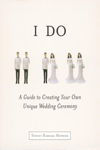

In [37]:
# Create a filter definition to filter for books where the `year` field is greater than or equal to `2002` and the `pages` field is less than or equal to 250
# Use the `$gte` and `$lte` operators
filter = {"$and": [{"year": {"$gte": 2002}}, {"pages": {"$lte": 250}}]}
# Pass the `filter` as an argument to the `vector_search` function.
# Notice how this filter is incorporated in the `pipeline` in the `vector_search` function.
vector_search("A peaceful and uplifting atmosphere", "text", filter)

# Step 8: Changing the similarity metric

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#syntax

In [38]:
# Modify the vector search index `model` from Step 5 to change the similarity metric to `dotProduct`
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "dotProduct",
            },
        ]
    },
}

In [39]:
# Re-create the vector search index with the modified model
collection.drop_search_index(name=ATLAS_VECTOR_SEARCH_INDEX_NAME)
collection.create_search_index(model=model)

'vector_index'

In [40]:
# Verify that the index definition has the correct similarity metric and is in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}},
 {'id': '6824bd7ec1a00a285d630aef',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'dotProduct'}]}}]

Country Living Decorating with Candles: Accents for Every Room(2000, 112 pages): 15.757176399230957


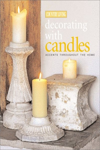

Funny Kittens (Welcome Books (Steward Tabori & Chang))(2000, 72 pages): 12.5184326171875


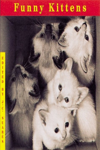

Beauty for Ashes: Receiving Emotional Healing(2003, 272 pages): 12.43799114227295


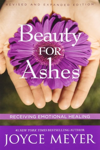

The Water and the Blood: A Novel(2001, 416 pages): 12.395434379577637


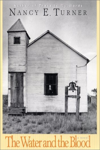

Sea Feather (An Avon Camelot Book)(1999, 74 pages): 12.382891654968262


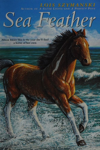

In [41]:
# Perform a vector search
# Note any differences in the results due to the different similarity metric
vector_search("A peaceful and uplifting atmosphere", "text")

# 🦹‍♀️ Enable vector quantization

📚 https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/#syntax

In [42]:
# Modify the vector search index `model` from Step 5 to use `scalar` quantization
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "cosine",
                "quantization": "scalar",
            },
        ]
    },
}

In [43]:
# Re-create the vector search index with the modified model
collection.drop_search_index(name=ATLAS_VECTOR_SEARCH_INDEX_NAME)
collection.create_search_index(model=model)

'vector_index'

In [44]:
# Verify the index was created with quantization enabled
list(collection.list_search_indexes())

[{'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}},
 {'id': '6824bd93c1a00a285d630af0',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'cosine',
     'quantization': 'scalar'}]}}]

# 🦹‍♀️ Hybrid search

In [45]:
# Name of the full-text search index
ATLAS_FTS_INDEX_NAME = "fts_index"

In [46]:
# Create full-text search index definition specifying the field mappings
model = {
    "name": ATLAS_FTS_INDEX_NAME,
    "type": "search",
    "definition": {
        "mappings": {"dynamic": False, "fields": {"title": {"type": "string"}}}
    },
}

In [47]:
# Create a full-text search index with the above definition for the `collection` collection
collection.create_search_index(model=model)

'fts_index'

In [48]:
# Reset the vector search index to the original vector search index definition
model = {
    "name": ATLAS_VECTOR_SEARCH_INDEX_NAME,
    "type": "vectorSearch",
    "definition": {
        "fields": [
            {
                "type": "vector",
                "path": "embedding",
                "numDimensions": 512,
                "similarity": "cosine",
            }
        ]
    },
}

collection.drop_search_index(name=ATLAS_VECTOR_SEARCH_INDEX_NAME)
collection.create_search_index(model=model)

'vector_index'

In [51]:
# Verify that both the indexes were created and are in READY status before proceeding
list(collection.list_search_indexes())

[{'id': '6824bb43c1a00a285d630ae9',
  'name': 'fts_index',
  'type': 'search',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'mappings': {'dynamic': False,
    'fields': {'title': {'type': 'string',
      'indexOptions': 'offsets',
      'store': True,
      'norms': 'include'}}}}},
 {'id': '6824bda3c1a00a285d630af2',
  'name': 'vector_index',
  'type': 'vectorSearch',
  'status': 'READY',
  'queryable': True,
  'latestVersion': 0,
  'latestDefinition': {'fields': [{'type': 'vector',
     'path': 'embedding',
     'numDimensions': 512,
     'similarity': 'cosine'}]}}]

**NOTE:** Refer to our [documentation](https://www.mongodb.com/docs/atlas/atlas-vector-search/tutorials/reciprocal-rank-fusion/#about-the-query) for a detailed explanation of the hybrid search query below.

In [52]:
def hybrid_search(
    user_query: str, vector_weight: float, full_text_weight: float
) -> None:
    """
    Retrieve relevant documents for a user query using hybrid search.

    Args:
        user_query (str): User query string
        vector_weight (float): Weight of vector search in the final search results
        full_text_weight (float): Weight of full-text search in the final search results
    """
    pipeline = [
        # Vector search stage
        {
            "$vectorSearch": {
                "index": ATLAS_VECTOR_SEARCH_INDEX_NAME,
                "path": "embedding",
                "queryVector": get_embedding(user_query, "text"),
                "numCandidates": 50,
                "limit": 10,
            }
        },
        # Group all documents returned by the vector search into a single array named `docs`
        {"$group": {"_id": None, "docs": {"$push": "$$ROOT"}}},
        # Unwinds the array of documents in the `docs` field and stores the position of the document in the `docs` array, in a field named `rank`
        {"$unwind": {"path": "$docs", "includeArrayIndex": "rank"}},
        # Adds a new field named `vs_score` that contains the reciprocal rank score for each document in the `docs` array
        {
            "$addFields": {
                "vs_score": {
                    "$multiply": [
                        vector_weight,
                        {"$divide": [1.0, {"$add": ["$rank", 60]}]},
                    ]
                }
            }
        },
        # Includes only the fields `_id`, `title`, and `cover` and the `vs_score` in the results
        {
            "$project": {
                "vs_score": 1,
                "_id": "$docs._id",
                "title": "$docs.title",
                "cover": "$docs.cover",
            }
        },
        # Union with a full-text search stage
        {
            "$unionWith": {
                "coll": COLLECTION_NAME,
                "pipeline": [
                    # Full-text search
                    {
                        "$search": {
                            "index": ATLAS_FTS_INDEX_NAME,
                            "text": {"query": user_query, "path": "title"},
                        }
                    },
                    # Limits the number of documents returned by the full-text search to 10
                    {"$limit": 10},
                    # Group all documents returned by the full-text search into a single array named `docs`
                    {"$group": {"_id": None, "docs": {"$push": "$$ROOT"}}},
                    # Unwinds the array of documents in the `docs` field and stores the position of the document in the `docs` array, in a field named `rank`
                    {"$unwind": {"path": "$docs", "includeArrayIndex": "rank"}},
                    # Adds a new field named `fts_score` that contains the reciprocal rank score for each document in the `docs` array
                    {
                        "$addFields": {
                            "fts_score": {
                                "$multiply": [
                                    full_text_weight,
                                    {"$divide": [1.0, {"$add": ["$rank", 60]}]},
                                ]
                            }
                        }
                    },
                    # Includes only the fields `_id`, `title`, and `cover` and the `fts_score` in the results
                    {
                        "$project": {
                            "fts_score": 1,
                            "_id": "$docs._id",
                            "title": "$docs.title",
                            "cover": "$docs.cover",
                        }
                    },
                ],
            }
        },
        # The following stages combine the results from vector and full-text search into a single ranked list
        # Groups the documents in the results from the preceding stages by `title`, `vs_score`, and `fts_score`
        {
            "$group": {
                "_id": "$_id",
                "title": {"$first": "$title"},
                "vs_score": {"$max": "$vs_score"},
                "fts_score": {"$max": "$fts_score"},
                "cover": {"$first": "$cover"},
            }
        },
        # Includes only the fields `_id`, `title`, `cover`, `vs_score` and `fts_score` in the results
        {
            "$project": {
                "_id": 1,
                "title": 1,
                "vs_score": {"$ifNull": ["$vs_score", 0]},
                "fts_score": {"$ifNull": ["$fts_score", 0]},
                "cover": 1,
            }
        },
        # Adds a field named `score` that contains the sum of `vs_score` and `fts_score` to the results
        {
            "$project": {
                "score": {"$add": ["$fts_score", "$vs_score"]},
                "_id": 1,
                "title": 1,
                "vs_score": 1,
                "fts_score": 1,
                "cover": 1,
            }
        },
        # Sorts the results by descending order of `score`
        {"$sort": {"score": -1}},
        # Limits the output to 5 results only
        {"$limit": 5},
    ]

    results = collection.aggregate(pipeline)

    # Print book title, scores, and cover image
    for book in results:
        cover = Image.open(requests.get(book["cover"], stream=True).raw).resize(
            (100, 150)
        )
        print(
            f"{book.get('title')}, VS Score: {book.get('vs_score')}, FTS Score: {book.get('fts_score')}"
        )
        display(cover)

Sea Feather (An Avon Camelot Book), VS Score: 0.016666666666666666, FTS Score: 0


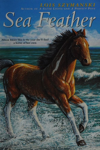

Café Royale: Tales of love & travel, VS Score: 0.01639344262295082, FTS Score: 0


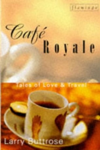

Ocean Sea, VS Score: 0.016129032258064516, FTS Score: 0


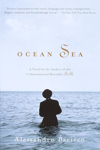

Raising Blaze: A Mother and Son's Long, Strange Journey into Autism, VS Score: 0.015873015873015872, FTS Score: 0


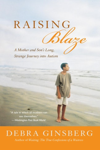

Dragon of the Lost Sea (Dragon Series), VS Score: 0.015625, FTS Score: 0


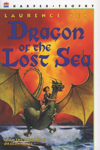

In [53]:
# Test the hybrid search query with a weight of 1.0 for vector search and 0.0 for full-text search
hybrid_search(
    user_query="A Winter's Tale on a Spanish Isle",
    vector_weight=1.0,
    full_text_weight=0.0,
)

Snowball Oranges: A Winter's Tale on a Spanish Isle, VS Score: 0, FTS Score: 0.008333333333333333


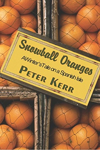

Sea Feather (An Avon Camelot Book), VS Score: 0.008333333333333333, FTS Score: 0


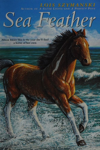

Café Royale: Tales of love & travel, VS Score: 0.00819672131147541, FTS Score: 0


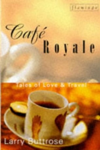

On Lee's To Kill a Mockingbird (Cliffs Notes), VS Score: 0, FTS Score: 0.00819672131147541


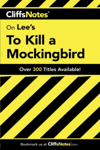

Iron Lady: A Biographical Thriller, VS Score: 0, FTS Score: 0.008064516129032258


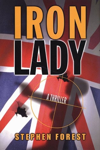

In [55]:
# Test the hybrid search query with a weight of 0.5 for vector search and 0.5 for full-text search
hybrid_search(
    user_query="A Winter's Tale on a Spanish Isle",
    vector_weight=0.5,
    full_text_weight=0.5,
)